In [96]:
import sys
import wikipedia
import numpy as np
import pandas as pd

from qubo_util import *
from dwave_qbsolv import QBSolv


In [97]:
np.set_printoptions(suppress=True)

##### Lasst uns neue randomisierte Daten Erzeugen:

In [98]:
data_generator_trumpf()

Fertig!


##### Und davon fangen wir mit den ersten 5 Jobs an

In [99]:
jobs = import_from_txt()
jobs = jobs[:6]
jobs

[(0, 0, 4, 6, 0, 180),
 (0, 1, 5, 5, 0, 180),
 (0, 2, 8, 0, 0, 180),
 (1, 0, 1, 12, 8, 276),
 (1, 1, 5, 0, 6, 276),
 (1, 2, 1, 0, 3, 276)]

In [100]:
jobs = [(0, 0, 5, 2, 0, 7),
 (0, 1, 3, 8, 4, 7),
 (1, 0, 2, 14, 0, 15),
 (1, 1, 6, 13, 2, 15),
 (2, 0, 7, 0, 3, 18),
 (2, 1, 5, 9, 4, 18)]

In [101]:
jobs

[(0, 0, 5, 2, 0, 7),
 (0, 1, 3, 8, 4, 7),
 (1, 0, 2, 14, 0, 15),
 (1, 1, 6, 13, 2, 15),
 (2, 0, 7, 0, 3, 18),
 (2, 1, 5, 9, 4, 18)]

In [102]:
### Lets define the basics

bend = [0, 1, 2]
weld = [3, 4]
paint =  [5]

bend_length = 2
weld_length = 3
paint_length = 6

t_step = 3
t_step_in_sec = 30

In [103]:
# OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate 

m_t_steps = max_time(jobs, bend_length, weld_length, paint_length)

m_time = m_t_steps * t_step_in_sec
    
print('The maximal maketime for the given operations is: ' + str(m_time) + ' second(s).\nWhich is equal to: ' + str(m_t_steps) + ' time steps.\n\n')


The maximal maketime for the given operations is: 6270 second(s).
Which is equal to: 209 time steps.




In [104]:
operations = ops(jobs, bend, weld, paint, bend_length, weld_length, paint_length, t_step)

print('Anzahl an Kombinationen: ' + str(len(operations)) + '\n')

Anzahl an Kombinationen: 1746



In [105]:
QUBO = np.zeros((len(operations), len(operations)))

In [106]:
#get_qubo_heatmap(QUBO, operations, "empty_QUBO")

In [107]:
# H0: Mehrmaliges abarbeiten der selben Operation eines Bauteils eines Jobs bestrafen

alpha = 2
QUBO = h0_constraint(QUBO, operations, bend, weld, paint, alpha)
#QUBO = h0_constraint(QUBO, operations, jobs, bend, weld, paint, bend_length, weld_length, paint_length, m_t_steps, t_step, alpha)

In [108]:
#get_qubo_heatmap(QUBO, operations, "h0_QUBO")

In [109]:
'Format: OrderNo, PartNo, Op, Machine, Time \n'
# H1 verbotene Reihenfolgen innerhalb eines Bauteils eines Jobs bestrafen

beta = 1.5

QUBO = h1_constraint(QUBO, operations, bend, weld, paint, bend_length, weld_length, beta)

In [110]:
#get_qubo_heatmap(QUBO, operations, "h1_QUBO")

In [111]:
'Format: OrderNo, PartNo, Op, Machine, Time \n'
# H2 Geichzeitiges Laufen zweier verschiedener Operationen auf der selben Machine

gamma = 2

QUBO = h2_constraint(QUBO, operations, weld, paint, bend_length, weld_length, paint_length, gamma)

In [112]:
#get_qubo_heatmap(QUBO, operations, "h2_QUBO")

In [113]:
# ops =  OrderNo, PartNo, OpNum, Machine, Time
# job = OrderNo, PartNo, BendingLines, WeldingPoints, PaintTime, DueDate
# K Bestrafung für Verspätung

delta = 0.035

QUBO = h3_constraint(QUBO, jobs, operations, weld, paint, bend_length, weld_length, paint_length, delta)

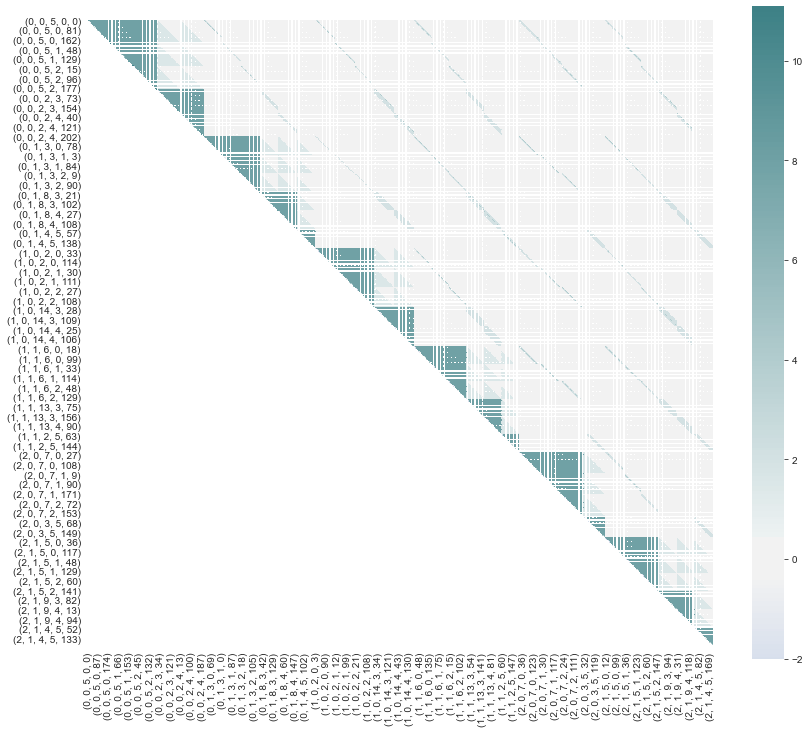

In [114]:
get_qubo_heatmap(QUBO, operations, "h3_QUBO")

In [ ]:
qubo_dictionary = qubo_to_dictionary(QUBO, operations)

In [ ]:
# solve and print first result
result = QBSolv().sample_qubo(qubo_dictionary)
print(result)

In [ ]:
schedule = get_results(result, operations, 0)

In [ ]:
df_schedule = make_result_df(schedule, jobs, bend_length, weld_length, paint_length)


In [ ]:
df_schedule

In [ ]:
get_qubo_ganttchart(df_schedule)

In [ ]:
jobs_df = pd.DataFrame(jobs, columns=["OrderNo", "PartNo", "BendLines", "WeldLines", "PaintMins", "DueDate"])
jobs_df

### Comparison of best Results

In [ ]:
get_qubo_ganttchart(make_result_df(get_results(result, operations, 0), jobs, bend_length, weld_length, paint_length))

In [ ]:
get_qubo_ganttchart(make_result_df(get_results(result, operations, 1), jobs, bend_length, weld_length, paint_length))

In [ ]:
get_qubo_ganttchart(make_result_df(get_results(result, operations, 2), jobs, bend_length, weld_length, paint_length))

In [ ]:
get_qubo_ganttchart(make_result_df(get_results(result, operations, 3), jobs, bend_length, weld_length, paint_length))

### Parameter:  $\alpha, \beta, \gamma, \delta$

 $\alpha$ at $2$ because its a *hard* constraint - it must not be broken
 
 $\beta$ at $1$ because its a *soft* constraint - it should not be broken
 
 $\gamma$ at $2$ because its a *hard* constraint - it must not be broken
 
 $\delta$ at $0.033$ so it has an effect in the same realm as the constraints
 

### Next Steps: 

##### TODOS:

###### Prio allgemein:

- Automatische Validierung (Viki ist fast fertig)
- Parameter Optimization for $\alpha, \beta, \gamma, \delta$
- start Paper with LaTex Template
- How to interprete findings? --> Compare with Papers from Lecture



###### Prio Annealing:

- Produce results on D Wave and Fujitsu Annealers with small Problems (e.g. 2 Jobs)
- Divide-and-conquer with D-Wave Neal ```Itertools``` and ```dwave-hybrid```
- Energy, Chain Strength and dedicated Visualizations

###### Prio Gate Model:

- PennyLane
- Amazon Bracket Account


###### VL Notes:

        // Deutsch, 10 Seiten mit Struktur der Paper
        // TOP 0: Motivation hinter QC und diesem expliziten Problem
        // Überblick und weiterführende Struktur als Übergang zu 1. TOP
        // TOP 1: Grundlagen: Problemstellung mathematisch aufzeigen, Definitionen, Nebenbedingungen
        // TOP 1a: Wie funktioniert Quantum Annealing; Wieso QA;
        // TOP 1b: Wie funktioniert Quantum Gate Model; Wieso QGM; QAOA?
        // Hardware Vergleich analog zu Papern?
        // Verwandte Arbeiten
        // TOP 2: Konzept --> WIE und WARUM des Vorgehens erklären
        // TOP 3: Evaluation --> Welcher Algo/QUBO mit welchem Rechner ausgeführt
        // Plots mit Evaluation (Richtige oder Falsche Lösungen?)--> viele Versuche
        // Paper zu Evaluation: Vehicle Routing mit guter Auswertung vom Lehrstuhl
        // ++ QAOA Paper vom Lehrstuhl
        // Vergleich mit klassischen Approach (generischer JSSP Algo)
        // TOP 4: Fazit und Conclusion --> Einordnen bzgl Quanten Vorteil --> Besser/Schlechter bei Hardware?
        // Ausblick und künftiger Forschungsschwerpunkt
        // Abstract am Ende in möglichst komprimierter Version
        // Management Summary in Alltagssprache "explain like i'm 5"